# Naive Bayes Assignment

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle 

from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import label_binarize
import seaborn as sns


In [2]:
# function to load the pickle data
def loadPickleData(filename):
    pickle_off = open(filename,"rb")
    final = pickle.load(pickle_off)
    return final


In [3]:
# load the y values because they are common across all feature engineering
y_train = loadPickleData('y_train.pickle')
y_test = loadPickleData('y_test.pickle')
y_cv = loadPickleData('y_cv.pickle')

In [4]:
encoded_column_vector = label_binarize(y_train, classes=['negative','positive']) 
y_train = np.ravel(encoded_column_vector)

encoded_column_vector = label_binarize(y_test, classes=['negative','positive']) 
y_test = np.ravel(encoded_column_vector)

encoded_column = label_binarize(y_cv, classes=['negative','positive']) 
y_cv = np.ravel(encoded_column)


In [5]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [6]:
def calculateMetric(X,y,alpha,train,y_train):
    fpr_array =[]
    for i in alpha:
            print("for alpha =", i)
            clf = MultinomialNB(alpha=i)
            clf.fit(train, y_train)
            pred = clf.predict(X)
            tn, fp, fn, tp = confusion_matrix(y, pred,labels=[0,1]).ravel()
            if fp == 0 and tp ==0:
                fpr = np.inf
            else:
                fpr = fp/(fp+tn)  
            fpr_array.append(fpr)
            # to avoid rounding error while multiplying probabilites we use log-probability estimates
            print("FPR :",fpr)   
    return fpr_array

In [7]:
# function to perform cross validation 
def performCrossValidation(train,cv,test):
    alpha = [10**x for x in range(-8,3)]
#     fpr_array = []
#     fpr_array_train = []
#     for i in alpha:
#         print("for alpha =", i)
#         clf = MultinomialNB(alpha=i)
#         clf.fit(train, y_train)
#         pred = clf.predict(cv)
#         tn, fp, fn, tp = confusion_matrix(y_cv, pred,labels=[0,1]).ravel()
#         if fp == 0 and tp ==0:
#             fpr = np.inf
#         else:
#             fpr = fp/(fp+tn)  
#         fpr_array.append(fpr)
#         # to avoid rounding error while multiplying probabilites we use log-probability estimates
#         print("FPR :",fpr) 
    fpr_array = calculateMetric(cv,y_cv,alpha,train,y_train)
    fpr_array_train = calculateMetric(train,y_train,alpha,train,y_train)
#     for i in alpha:
#         print("for alpha =", i)
#         clf = MultinomialNB(alpha=i)
#         clf.fit(train, y_train)
#         pred = clf.predict(train)
#         tn, fp, fn, tp = confusion_matrix(y_train, pred,labels=[0,1]).ravel()
#         if fp == 0 and tp ==0:
#             fpr = np.inf
#         else:
#             fpr = fp/(fp+tn)  
#         fpr_array_train.append(fpr)
#         # to avoid rounding error while multiplying probabilites we use log-probability estimates
#         print("FPR :",fpr) 
    a = np.arange(len(alpha))
    fig, ax = plt.subplots(figsize=(15,15))
    ax.plot(a, fpr_array,c='g',label = 'cross validation')
    for i, txt in enumerate(np.round(fpr_array,3)):
        ax.annotate((a[i],str(txt)), (a[i],fpr_array[i]))
    ax.plot(a, fpr_array_train,c='r',label ='train')
    for i, txt in enumerate(np.round(fpr_array_train,5)):
        ax.annotate((a[i],np.round(txt,5)), (a[i],fpr_array_train[i]))
    ax.set_xticks(a)
    ax.set_xticklabels(alpha)
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.legend(loc= 4)
    plt.show()
    
    best_alpha = np.argmin(fpr_array)
    clf = MultinomialNB(alpha=alpha[best_alpha])
    clf.fit(train, y_train)


    predict_y = clf.predict(train)
    tn, fp, fn, tp = confusion_matrix(y_train, predict_y).ravel()                     
    print('For values of best alpha = ', alpha[best_alpha], "The train fpr is:",fp/(fp+tn))
    plot_confusion_matrix(y_train,predict_y)
    predict_y = clf.predict(cv)
    tn, fp, fn, tp = confusion_matrix(y_cv, predict_y).ravel()
    print('For values of best alpha = ', alpha[best_alpha], "The cross validation fpr is:",fp/(fp+tn))
    print(confusion_matrix(y_cv,predict_y))
    predict_y = clf.predict(test)
    tn, fp, fn, tp = confusion_matrix(y_test, predict_y).ravel()      
    print('For values of best alpha = ', alpha[best_alpha], "The test fpr is:",fp/(fp+tn))
    plot_confusion_matrix(y_test,predict_y)
    return alpha[best_alpha]

In [8]:
def performNB(train,test,al):    
    clf = MultinomialNB(alpha=al)
    clf.fit(train, y_train)
    pred = clf.predict(test)
    return pred,clf

In [9]:
def printNegativeWords(negative_words_arg,index_word_dict):
    negative_words= []
    for x in negative_words_arg[:20]:
        negative_words.append(index_word_dict[x])
    print(negative_words)

In [10]:
def printPositiveWords(postive_words_arg,index_word_dict):
    positive_words = []
    for x in positive_words_arg[:20]:
        positive_words.append(index_word_dict[x])
    print(positive_words)

# BOW

In [11]:
count_vect = loadPickleData('count_vect.pickle')

In [12]:
train = loadPickleData("bow_train.pickle")
test = loadPickleData('bow_test.pickle')
cv = loadPickleData('bow_cv.pickle')

In [13]:
train.shape

(69920, 15548)

for alpha = 1e-08
FPR : 0.437066763954761
for alpha = 1e-07
FPR : 0.437066763954761
for alpha = 1e-06
FPR : 0.4367019336008756
for alpha = 1e-05
FPR : 0.43378329076979205
for alpha = 0.0001
FPR : 0.4301349872309376
for alpha = 0.001
FPR : 0.42867566581539585
for alpha = 0.01
FPR : 0.4206493980299161
for alpha = 0.1
FPR : 0.40678584458226924
for alpha = 1
FPR : 0.3940167821962787
for alpha = 10
FPR : 0.5206129149945276
for alpha = 100
FPR : 0.9602334914264867
for alpha = 1e-08
FPR : 0.29457364341085274
for alpha = 1e-07
FPR : 0.29457364341085274
for alpha = 1e-06
FPR : 0.29457364341085274
for alpha = 1e-05
FPR : 0.29457364341085274
for alpha = 0.0001
FPR : 0.29457364341085274
for alpha = 0.001
FPR : 0.2944824441404469
for alpha = 0.01
FPR : 0.2944824441404469
for alpha = 0.1
FPR : 0.2947560419516644
for alpha = 1
FPR : 0.30013679890560874
for alpha = 10
FPR : 0.444140446876425
for alpha = 100
FPR : 0.9440036479708163


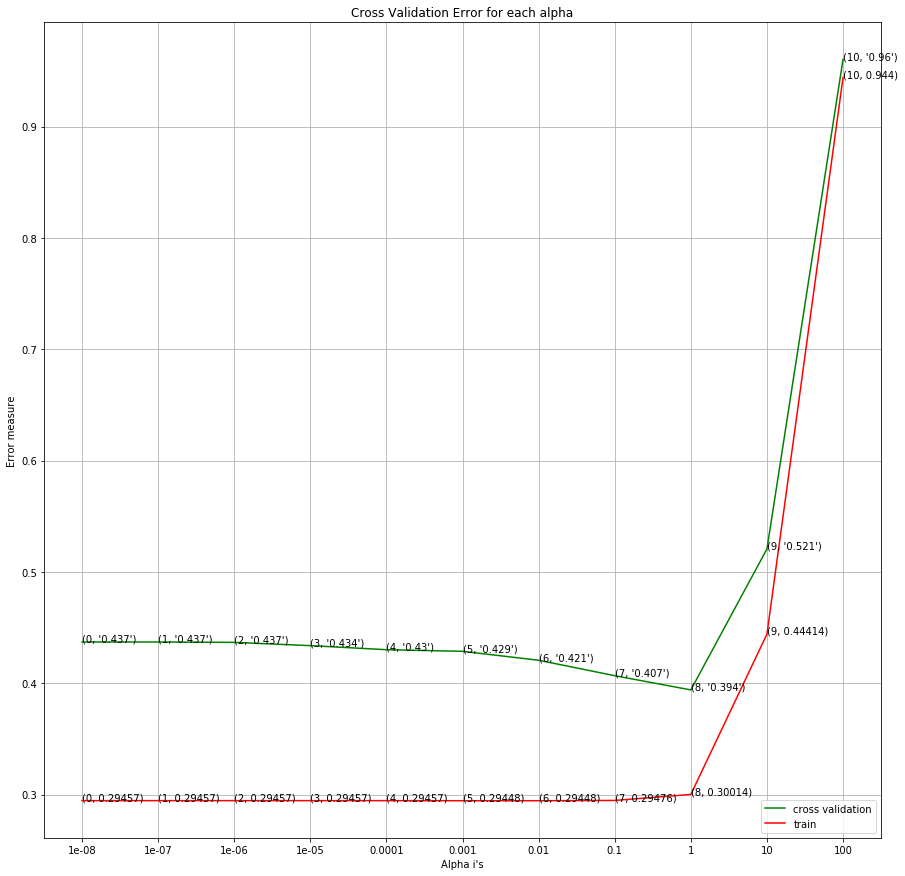

For values of best alpha =  1 The train fpr is: 0.30013679890560874
-------------------- Confusion matrix --------------------


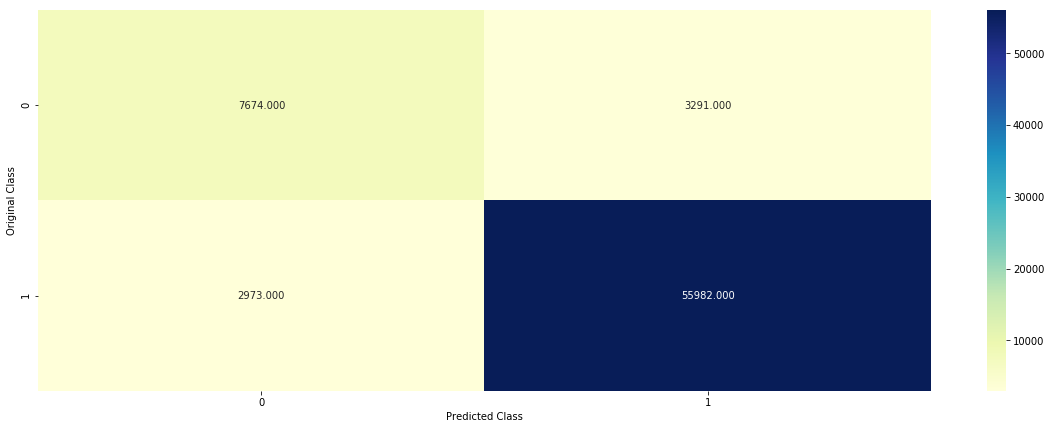

For values of best alpha =  1 The cross validation fpr is: 0.3940167821962787
[[ 1661  1080]
 [  827 13912]]
For values of best alpha =  1 The test fpr is: 0.40822877152028014
-------------------- Confusion matrix --------------------


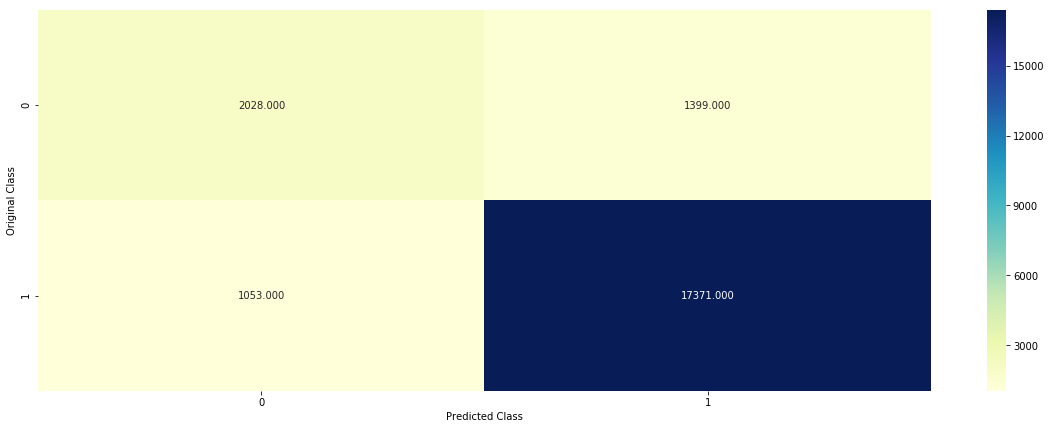

In [14]:
alpha = performCrossValidation(train,cv,test)

In [15]:
pred,clf = performNB(train,test,alpha)

In [16]:
print(y_test[:10])
print(pred[:10])

[0 1 1 1 1 1 1 0 1 1]
[1 1 0 1 1 1 1 1 1 1]


In [17]:
confusion_matrix(y_test,pred,labels=[0,1])

array([[ 2028,  1399],
       [ 1053, 17371]])

In [18]:
#precision-score
precision_score(y_test, pred, average='binary')  

0.925466169419286

In [19]:
#recall-score
recall_score(y_test, pred, average='binary')  

0.9428462874511506

In [20]:
#f1-score
f1_score(y_test, pred, average='binary') 

0.9340753885035221

In [21]:
#find most commom positive and negative works
index_word_dict = {y:x for x,y in count_vect.vocabulary_.items()}
negative_words_arg = clf.feature_log_prob_[0, :].argsort()[::-1]
positive_words_arg = clf.feature_log_prob_[1, :].argsort()[::-1]
printNegativeWords(negative_words_arg,index_word_dict)
printPositiveWords(positive_words_arg,index_word_dict)

['wast money', 'custom servic', 'expir date', 'wont buy', 'ingredi list', 'never buy', 'smell like', 'read review', 'save money', 'buy product', 'noth like', 'corn syrup', 'purchas product', 'coconut water', 'made china', 'dont wast', 'didnt like', 'doesnt tast', 'one star', 'throw away']
['coconut oil', 'ice tea', 'hot sauc', 'ice cream', 'love love', 'black tea', 'work great', 'best tast', 'find local', 'kid love', 'sugar free', 'well worth', 'easi make', 'last long', 'pleasant surpris', 'everi time', 'use make', 'also use', 'far best', 'good product']


# TfIdf

In [95]:
train = loadPickleData("tfidf_train.pickle")
test = loadPickleData('tfidf_test.pickle')
cv = loadPickleData('tfidf_cv.pickle')

In [96]:
train.shape

(69920, 46189)

In [97]:
tfidf_vect = loadPickleData('tf_idf_vect.pickle')

for alpha = 1e-08
FPR : 0.6355344764684422
for alpha = 1e-07
FPR : 0.6293323604523896
for alpha = 1e-06
FPR : 0.6234950747902226
for alpha = 1e-05
FPR : 0.6176577891280555
for alpha = 0.0001
FPR : 0.6045238963881795
for alpha = 0.001
FPR : 0.5870120394016782
for alpha = 0.01
FPR : 0.5625684056913535
for alpha = 0.1
FPR : 0.5421379058737686
for alpha = 1
FPR : 0.7223641006931777
for alpha = 10
FPR : 0.9985406785844583
for alpha = 100
FPR : 1.0
for alpha = 1e-08
FPR : 0.3126310989512084
for alpha = 1e-07
FPR : 0.3126310989512084
for alpha = 1e-06
FPR : 0.3126310989512084
for alpha = 1e-05
FPR : 0.3126310989512084
for alpha = 0.0001
FPR : 0.3126310989512084
for alpha = 0.001
FPR : 0.31272229822161424
for alpha = 0.01
FPR : 0.3147286821705426
for alpha = 0.1
FPR : 0.33506611947104425
for alpha = 1
FPR : 0.5975376196990424
for alpha = 10
FPR : 0.9979936160510716
for alpha = 100
FPR : 1.0


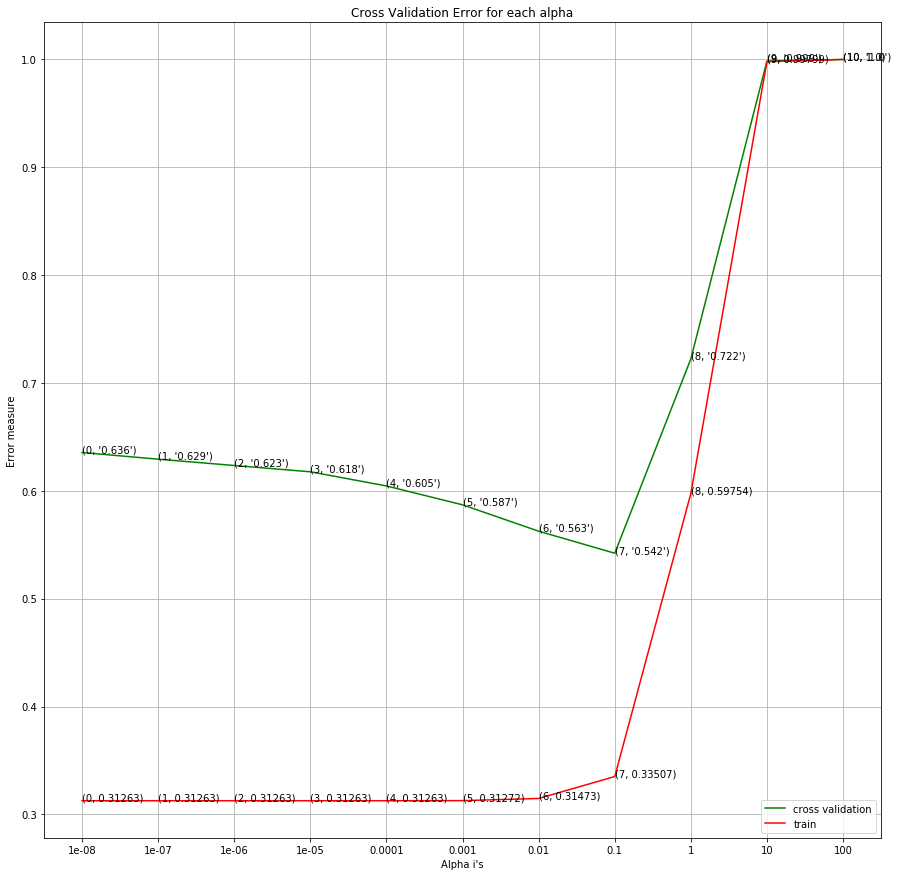

For values of best alpha =  0.1 The train fpr is: 0.33506611947104425
-------------------- Confusion matrix --------------------


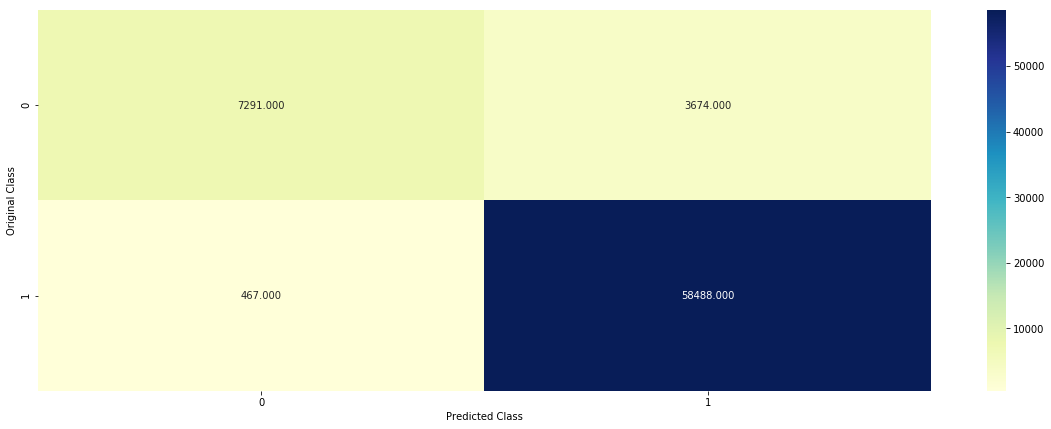

For values of best alpha =  0.1 The cross validation fpr is: 0.5421379058737686
[[ 1255  1486]
 [  161 14578]]
For values of best alpha =  0.1 The test fpr is: 0.5672599941639919
-------------------- Confusion matrix --------------------


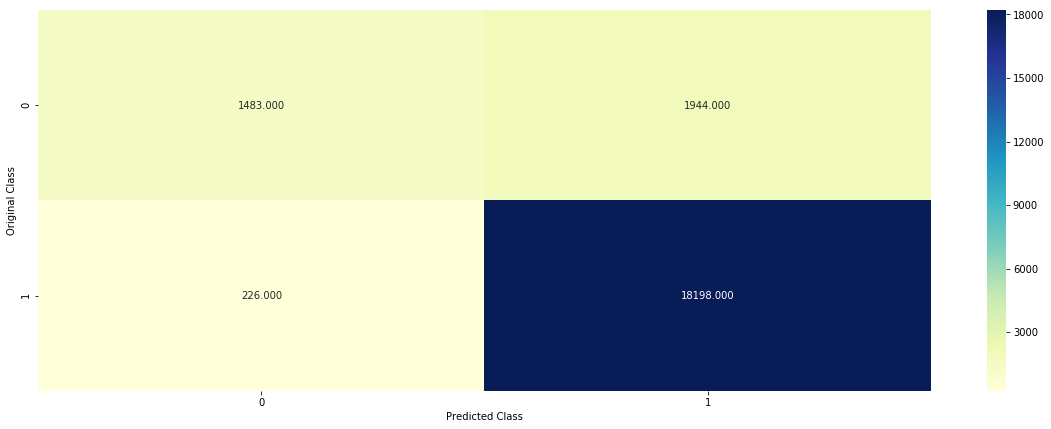

In [98]:
alpha = performCrossValidation(train,cv,test)

In [99]:
pred,clf = performNB(train,test,alpha)

In [100]:
#confusion-matrix
confusion_matrix(y_test,pred)

array([[ 1483,  1944],
       [  226, 18198]])

In [101]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
(tn, fp, fn, tp)

(1483, 1944, 226, 18198)

In [102]:
#precision-score
precision_score(y_test, pred, average='binary')  

0.903485254691689

In [103]:
#recall-score
recall_score(y_test, pred, average='binary')  

0.987733391228832

In [104]:
#f1-score
f1_score(y_test, pred, average='binary') 

0.9437328216563814

In [105]:
#find most commom positive and negative works
index_word_dict = {y:x for x,y in tfidf_vect.vocabulary_.items()}
negative_words_arg = clf.feature_log_prob_[0, :].argsort()[::-1]
positive_words_arg = clf.feature_log_prob_[1, :].argsort()[::-1]
printNegativeWords(negative_words_arg,index_word_dict)
printPositiveWords(positive_words_arg,index_word_dict)

['wast money', 'terribl', 'aw', 'horribl', 'stale', 'worst', 'pictur', 'descript', 'expir', 'threw', 'refund', 'broken', 'weak', 'poor', 'china', 'nasti', 'send', 'sorri', 'bland', 'pod']
['hair', 'espresso', 'pod', 'cherri', 'granola', 'mint', 'cocoa', 'tomato', 'chai', 'one best', 'great flavor', 'pancak', 'love product', 'hook', 'formula', 'make great', 'skin', 'absolut love', 'fun', 'veggi']


###  Summary

| Vectorizer | Alpha | FPR  |
|------------|-------|------|
| BOW        | 1     | 0.40 |
| TFIDF      | 0.1   | 0.56 |